<a href="https://colab.research.google.com/github/baudouindetruchis/VRP-RL/blob/main/VRP_DQN_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import random
import os
import time
from collections import deque 
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, ZeroPadding2D, Add, Input
from keras.utils.vis_utils import plot_model
from tqdm.notebook import tqdm
import tensorflow as tf
from keras.callbacks import TensorBoard
from google.colab import drive

# Check GPU
if not len(tf.test.gpu_device_name()):
    print("[WARNING] GPU not activated")

# Mount google drive
drive.mount('/content/drive')

[WARNING] GPU not activated
Mounted at /content/drive


### Parameters

In [4]:
##### ENVIRONMENT
GRID_SIZE = 10
N_POD = 15
HISTORY_SIZE = 2

##### MODEL
PATH = "/content/drive/MyDrive/VRP_DQN"
LOAD_MODEL = PATH + '/models/5x256C-D10-256__-74.7avg__1612922023.model'  # Filepath or None
MODEL_NAME = '5x256C-D10-256'

## Environment

In [5]:
class VRP:
    def __init__(self, grid_size=GRID_SIZE, n_pod=N_POD, history_size=HISTORY_SIZE):
        # Parameters
        self.grid_size = grid_size
        self.n_pod = n_pod
        self.history_size = history_size

        # Game states
        self.depot_grid = self.create_depot_grid()
        self.pod_grid = self.create_pod_grid()
        self.history = np.concatenate((np.expand_dims(self.depot_grid, axis=2),
                                       np.zeros((self.grid_size, self.grid_size, history_size), dtype=int)), axis=2)
        
        # Variables
        self.episode_step = 0
        self.route = [np.unravel_index(np.argmax(self.depot_grid, axis=None), self.depot_grid.shape)]     # Stores vehicule route

    # Give the position of the depot
    def create_depot_grid(self):
        depot_grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        depot_grid[np.random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)] = 1
        return depot_grid

    # Give position of PoD
    def create_pod_grid(self):
        pod_grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        for i in range(self.n_pod):
            random_x = np.random.randint(0, self.grid_size - 1)
            random_y = np.random.randint(0, self.grid_size - 1)
            # Reset if spot already taken
            while (self.depot_grid[random_x, random_y] == 1) or (pod_grid[random_x, random_y] == 1):
                random_x = np.random.randint(0, self.grid_size - 1)
                random_y = np.random.randint(0, self.grid_size - 1)
            pod_grid[random_x, random_y] = 1
        return pod_grid
    
    def get_observation(self):
        # Stack (create a new dimension) depot and PoD grid
        observation = np.concatenate((np.expand_dims(self.depot_grid, axis=2), np.expand_dims(self.pod_grid, axis=2)), axis=2)
        observation = np.concatenate((observation, self.history), axis=2)
        return observation
    
    # Get the closest point in a direction (if none get a random valid point)
    def direction_closest(self, action):
        # Current truck position
        current_position = self.history[:,:,0] - self.history[:,:,1]
        current_coordinates = np.unravel_index(np.argmax(current_position, axis=None), current_position.shape)
        # Get valid actions coordinates
        valid_actions = (env.depot_grid + env.pod_grid - env.history[:,:,0])
        valid_coordinates = np.argwhere(valid_actions == 1)
        # Transform into polar coordinates
        offset_coordinates = valid_coordinates.copy()
        offset_coordinates[:,0] = valid_coordinates[:,1] - current_coordinates[1]
        offset_coordinates[:,1] = -valid_coordinates[:,0] + current_coordinates[0]
        polar_coordinates = offset_coordinates.astype(float)
        polar_coordinates[:,0] = np.round(np.sqrt(offset_coordinates[:,0]**2 + offset_coordinates[:,1]**2), 2)
        polar_coordinates[:,1] = np.round(np.arctan2(offset_coordinates[:,1], offset_coordinates[:,0]), 2)
        # Select closest point in a direction (if no point in direction: random selection)
        direction_indexes = np.argwhere(((polar_coordinates[:,1] > (action*np.pi/4 - np.pi/4)) \
                                            & (polar_coordinates[:,1] < (action*np.pi/4 + np.pi/4))) \
                                        | ((polar_coordinates[:,1] + 2*np.pi > (action*np.pi/4 - np.pi/4)) \
                                            & (polar_coordinates[:,1] + 2*np.pi < (action*np.pi/4 + np.pi/4))))
        polar_coordinates[~direction_indexes.flatten()] = np.inf
        closest_index = np.argmin(polar_coordinates[:,0])
        return valid_coordinates[closest_index]
    
    # Total distance as the crow flies
    def get_total_distance(self):
        distance = 0
        for i in range(len(env.route)-1):
            distance += np.sqrt((env.route[i+1][0]-env.route[i][0])**2 + (env.route[i+1][1]-env.route[i][1])**2)
        return round(distance, 1)
    
    # Last step distance
    def get_step_distance(self):
        distance = np.sqrt((env.route[-1][0]-env.route[-2][0])**2 + (env.route[-1][1]-env.route[-2][1])**2)
        return round(distance, 1)
    
    def step(self, action):
        self.episode_step += 1
        # Update game states
        new_state = self.history[:,:,0].copy()
        new_coordinates = self.direction_closest(action)
        new_state[new_coordinates[0], new_coordinates[1]] = 1
        self.history = np.concatenate((np.expand_dims(new_state, axis=2), self.history[:,:,:-1]), axis=2).copy()
        # Save position for distance calculation
        current_position = self.history[:,:,0] - self.history[:,:,1]
        self.route.append(np.unravel_index(np.argmax(current_position, axis=None), current_position.shape))
        # Check if episode finished
        if (self.depot_grid + self.pod_grid == self.history[:,:,0]).all():
            done = True
            self.route.append(np.unravel_index(np.argmax(self.depot_grid, axis=None), self.depot_grid.shape))
            reward = - (self.get_step_distance() + self.get_total_distance())
        else:
            done = False
            reward = -self.get_step_distance()
        return self.get_observation(), reward, done

env = VRP()

## Agent

In [6]:
class Agent:
    def __init__(self):
        # Main model (train every step)
        self.model = self.create_model()
    
    def create_model(self):
        if LOAD_MODEL:
            print(f"[INFO] Loading model: {LOAD_MODEL}")
            model = load_model(LOAD_MODEL)
            print("[INFO] Model loaded")
        else:
            print("[ERROR] No model selected")
        return model

    def get_qs(self, state):
        return self.model.predict(state.reshape(-1, *state.shape))[0]

agent = Agent()

[INFO] Loading model: /content/drive/MyDrive/VRP_DQN/models/5x256C-D10-256__-74.7avg__1612922023.model
[INFO] Model loaded


## Testing

episode reward: -64.9
episode distance: -35.800000000000004


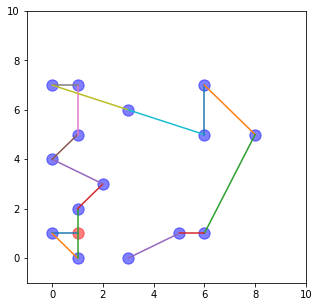

In [14]:
env = VRP()

# Environement initial state display
plt.figure(1, figsize=(5,5))
plt.xlim(-1, GRID_SIZE)
plt.ylim(-1, GRID_SIZE)
# Plot depot position
depot_grid = env.get_observation()[:,:,0]
plt.scatter(np.argwhere(depot_grid == 1)[:,0], np.argwhere(depot_grid == 1)[:,1], color='red', alpha=0.5, s=2**7)
# Plot PoD positions
pod_grid = env.get_observation()[:,:,1]
plt.scatter(np.argwhere(pod_grid == 1)[:,0], np.argwhere(pod_grid == 1)[:,1], color='blue', alpha=0.5, s=2**7)

done = False
current_state = env.get_observation()
episode_reward = 0
total_distance = 0
i = 1
# Loop through steps
while not done:
    action = np.argmax(agent.get_qs(current_state))
    # print(action)
    current_coor = np.unravel_index(np.argmax(env.get_observation()[:,:,2] - env.get_observation()[:,:,3]), env.get_observation()[:,:,0].shape)
    next_coor = env.direction_closest(action)
    plt.plot((current_coor[0], next_coor[0]), (current_coor[1], next_coor[1]))
    new_state, reward, done = env.step(action)
    episode_reward += reward
    total_distance = reward
    current_state = new_state
print('episode reward:', episode_reward)
print('episode distance:', total_distance)

## Sandbox

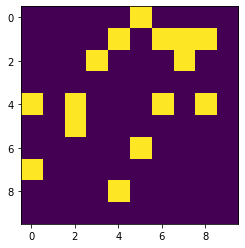

In [ ]:
plt.imshow(env.get_observation()[:,:,1])